# Predicting results

## Imports

In [1]:
import mysql.connector as sql
import pandas as pd
import numpy as np
from datetime import date, timedelta


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import tqdm

## Definitions

In [2]:
def get_prev_matches_numbers(date_start, date_end, team_id, df):
    dfteam_previous = df[((df["team_home_id"]==team_id) | (df["team_away_id"]==team_id)) & (df["kickoff_time"]<date_end) & (df["kickoff_time"]>date_start)].copy()
    if len(dfteam_previous) == 0:
        win_rate = 0.
        score_diff_avg = 0.
    else:    
        dfteam_previous["score_team"] = dfteam_previous.apply(lambda x: x["score_home"] if x["team_home_id"]==team_id else x["score_away"], axis=1)
        dfteam_previous["score_oponent"] = dfteam_previous.apply(lambda x: x["score_away"] if x["team_home_id"]==team_id else x["score_home"], axis=1)
        dfteam_previous["won"] = dfteam_previous["score_team"] > dfteam_previous["score_oponent"]
        dfteam_previous["score_diff"] = dfteam_previous["score_team"] - dfteam_previous["score_oponent"] 
        win_rate = float(dfteam_previous["won"].sum()) / len(dfteam_previous)
        score_diff_avg = dfteam_previous["score_diff"].mean()
    return win_rate, score_diff_avg

## Loading data from db

In [3]:
#DB connection
db_connection = sql.connect(host='localhost', port=3306, database='acb', user='root', password='root')
df_games = pd.read_sql('SELECT * FROM game where game.season >= 2016', con=db_connection)
print(df_games.shape)
print(df_games.columns)
df_games.head()

(784, 27)
Index(['id', 'game_acbid', 'team_home_id', 'team_away_id', 'season', 'journey',
       'competition_phase', 'round_phase', 'score_home', 'score_away',
       'score_home_first', 'score_away_first', 'score_home_second',
       'score_away_second', 'score_home_third', 'score_away_third',
       'score_home_fourth', 'score_away_fourth', 'score_home_extra',
       'score_away_extra', 'venue', 'attendance', 'kickoff_time', 'referee_1',
       'referee_2', 'referee_3', 'db_flag'],
      dtype='object')


,id,game_acbid,team_home_id,team_away_id,season,journey,competition_phase,round_phase,score_home,score_away,...,score_away_fourth,score_home_extra,score_away_extra,venue,attendance,kickoff_time,referee_1,referee_2,referee_3,db_flag
0,1,63001,1,9,2018,1,regular,None,88,73,...,18,None,None,WiZink Center,8791,2018-09-30 19:15:00,Jiménez Trujillo,Jordi Aliaga,Alfonso Olivares,None
1,2,63010,18,1,2018,2,regular,None,70,88,...,22,None,None,Pabellon Municipal Fuente San Luis,7782,2018-10-05 20:45:00,Antonio Conde,Oscar Perea,Rial,None
2,3,63100,3,2,2018,12,regular,None,78,73,...,20,None,None,Pal. De Deportes Jose Ma Martin Carpena,9750,2018-12-16 19:30:00,Carlos Peruga,Jordi Aliaga,Javier Torres,None
3,4,63101,17,10,2018,12,regular,None,83,68,...,15,None,None,Gran Canaria Arena,4985,2018-12-16 19:30:00,M.A. Pérez Pérez,J.R. García Ortiz,Esperanza Mendoza,None
4,5,63102,4,16,2018,12,regular,None,76,87,...,30,None,None,M.I. Govern Andorra,3814,2018-12-15 20:30:00,Daniel Hierrezuelo,Martín Caballero,A. Sánchez Sixto,None


## Correlations

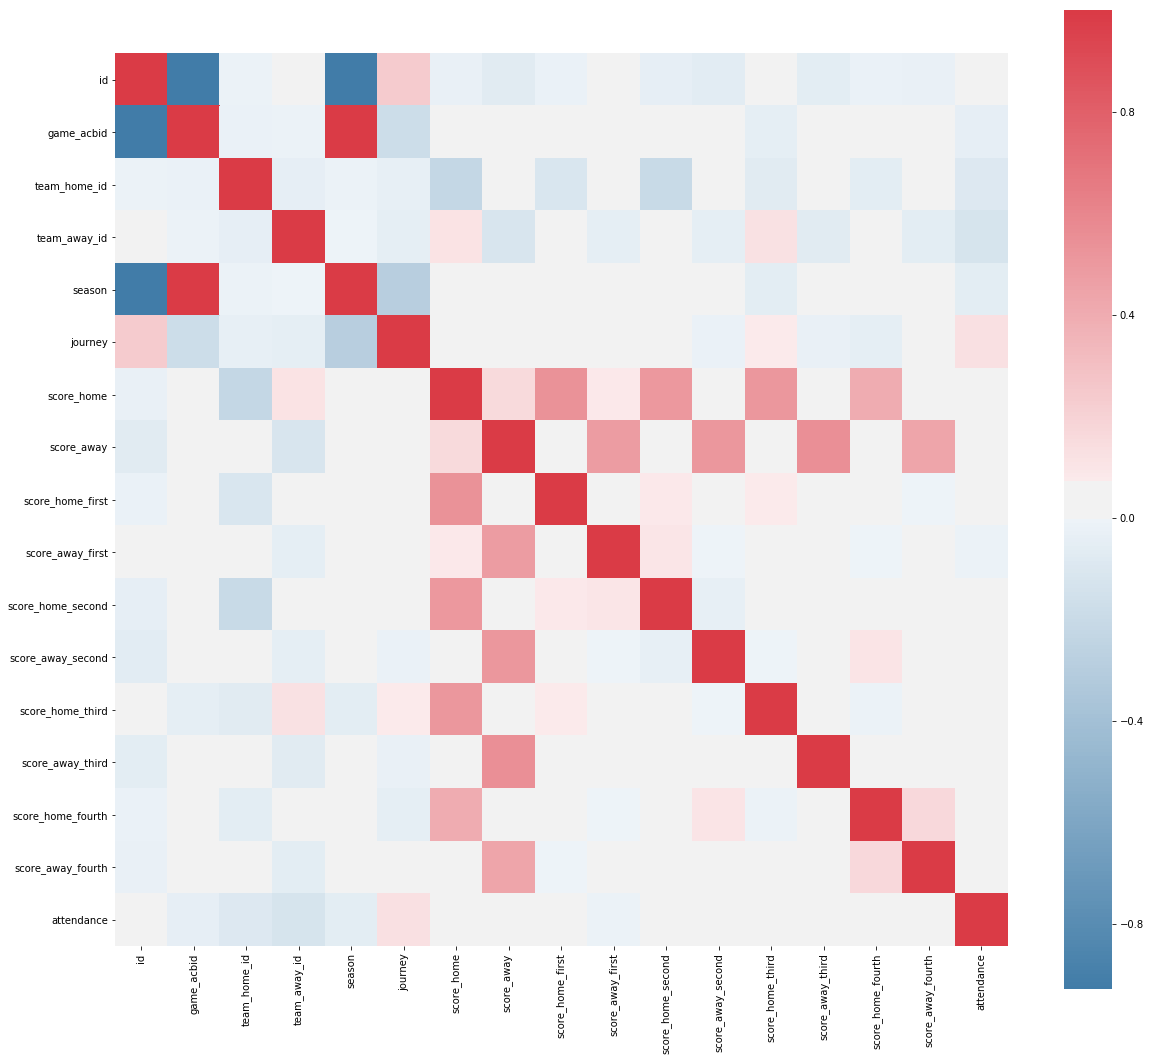

In [4]:
#correlation matrix
corrmat = df_games.corr()
f, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corrmat, square=True, cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.show()

In [5]:
"""cols_aux = [c for c in df_games.columns if (c.startswith("score") and not c.endswith("extra"))]
print(cols_aux)
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_games[cols_aux])
plt.show()"""

'cols_aux = [c for c in df_games.columns if (c.startswith("score") and not c.endswith("extra"))]\nprint(cols_aux)\nsns.set(style="ticks", color_codes=True)\nsns.pairplot(df_games[cols_aux])\nplt.show()'

## Preprocessing

In [6]:
# cols to keep
cols_to_keep = ['team_home_id', 'team_away_id', 'season', 'journey', 'kickoff_time',
       'score_home', 'score_away', 'referee_1']
cols_to_del = [c for c in df_games.columns if c not in cols_to_keep]
df_games.drop(cols_to_del, axis=1, inplace=True)

# check if nulls
print("Number of nulls in df:", df_games.isnull().sum().max())

# checking amount of times a home team won
win_home = df_games["score_away"] < df_games["score_home"]
print("Home Team Win percentage: {0:.1f}%".format(100 * win_home.values.sum() / len(win_home)))

# create score difference feature
df_games["score_difference"] = df_games["score_home"] - df_games["score_away"]
print("Mean of score difference:", df_games["score_difference"].mean())

# for each game add results of last ones
win_rate_home_list = []
win_rate_away_list = []
score_diff_avg_home_list = []
score_diff_avg_away_list = []
for i, row in tqdm(df_games.iterrows()):
    date_end=row["kickoff_time"]
    date_start=date_end-timedelta(days=100)
    # For the home team
    team_id = row["team_home_id"]
    #print("Home team:", team_id)
    win_rate_home, score_diff_avg_home = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
    win_rate_home_list+=[win_rate_home]
    score_diff_avg_home_list+=[score_diff_avg_home]
    # For the away team
    team_id = row["team_away_id"]
    #print("Away team:", team_id)
    win_rate_away, score_diff_avg_away = get_prev_matches_numbers(date_start, date_end, team_id, df_games)
    win_rate_away_list+=[win_rate_away]
    score_diff_avg_away_list+=[score_diff_avg_away]
    
# add historical to df
df_games["win_rate_home"] = win_rate_home_list
df_games["score_diff_avg_home"] = score_diff_avg_home_list
df_games["win_rate_away"] = win_rate_away_list
df_games["score_diff_avg_away"] = score_diff_avg_away_list

df_games.head()

Number of nulls in df: 0
Home Team Win percentage: 62.4%
Mean of score difference: 4.4438775510204085


784it [00:18, 42.49it/s]


,team_home_id,team_away_id,season,journey,score_home,score_away,kickoff_time,referee_1,score_difference,win_rate_home,score_diff_avg_home,win_rate_away,score_diff_avg_away
0,1,9,2018,1,88,73,2018-09-30 19:15:00,Jiménez Trujillo,15,0.000000,0.000000,0.000000,0.000000
1,18,1,2018,2,70,88,2018-10-05 20:45:00,Antonio Conde,-18,0.000000,-13.000000,1.000000,15.000000
2,3,2,2018,12,78,73,2018-12-16 19:30:00,Carlos Peruga,5,0.727273,6.000000,0.909091,13.181818
3,17,10,2018,12,83,68,2018-12-16 19:30:00,M.A. Pérez Pérez,15,0.272727,-4.454545,0.545455,-3.090909
4,4,16,2018,12,76,87,2018-12-15 20:30:00,Daniel Hierrezuelo,-11,0.454545,-3.636364,0.181818,-10.545455


In [7]:
df_final = df_games.copy()
#df_final.drop(["score_home", "score_away", "kickoff_time", "referee_1"], axis=1, inplace=True)
df_final = df_final[["win_rate_home", "score_diff_avg_home", "win_rate_away", "score_diff_avg_away", "season","score_difference"]]

# 2016-2017 for train // 2018 for test 
train = df_final[df_final["season"]<2018]
test = df_final[df_final["season"]==2018]

X_train = train.drop(['season', 'score_difference'], axis=1)
y_train = train['score_difference']
X_test = test.drop(['season', 'score_difference'], axis=1)
y_test = test['score_difference']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

"""
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

score_train=logreg.score(X_train,y_train)
score_test=logreg.score(X_test,y_test)

print("Training set accuracy: ", "%.3f"%(score_train))
print("Test set accuracy: ", "%.3f"%(score_test))
"""

clf = RandomForestClassifier(n_estimators=100,random_state = 0, max_depth=10)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

y_pred = clf.predict(X_test)

d = {'Real': y_test, 'Pred': y_pred}
df_res = pd.DataFrame(data=d)
df_res["winner_correct?"] = np.sign(df_res["Real"]) == np.sign(df_res["Pred"])

print("Mean absolute error: {} points".format(metrics.mean_absolute_error(y_test, y_pred)))
print("Percentage of the times the winner was correct: {}%".format(float(df_res["winner_correct?"].sum())/len(df_res)))

display(df_res)

[0.20392224 0.29416302 0.20315314 0.2987616 ]
Mean absolute error: 12.975308641975309 points
Percentage of the times the winner was correct: 0.5802469135802469%


,Pred,Real,winner_correct?
0,6,15,True
1,-5,-18,True
2,-6,5,False
3,26,15,True
4,-7,-11,True
5,-6,10,False
6,2,-10,False
7,-15,13,False
8,4,7,True
9,25,10,True
